# Customer Churn Prediction in Banking

## Welcome to my project: My mission is to build a basic model that can tell us whether a customer is likely to stay or leave a bank.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc

# Load the databases

In [2]:
# Load the train.csv
train_csv_path = '/kaggle/input/playground-series-s4e1/train.csv'
df_train = pd.read_csv(train_csv_path)

# Load the test.csv
test_csv_path = '/kaggle/input/playground-series-s4e1/test.csv'
df_test = pd.read_csv(test_csv_path)

# Remove unnecessary columns and check for empty fields

In [3]:
# Remove unnecessary columns 'CustomerId' and 'Surname'
df_train = df_train.drop(['CustomerId', 'Surname'], axis=1)
df_test = df_test.drop(['CustomerId', 'Surname'], axis=1)

# Check for missing values
print("Missing values in training set:\n", df_train.isnull().sum())
print("\nMissing values in test set:\n", df_test.isnull().sum())

Missing values in training set:
 id                 0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

Missing values in test set:
 id                 0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
dtype: int64


# Training

In [4]:
# Split the training set into features (X) and target variable (y)
X_train = df_train.drop(['Exited'], axis=1)
y_train = df_train['Exited']

# Define transformations for numeric and categorical columns
numeric_features = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

categorical_features = ['Geography', 'Gender', 'NumOfProducts']
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_features),('cat', categorical_transformer, categorical_features)])

# Create the pipeline with the preprocessor and model
pipeline = Pipeline(steps=[('preprocessor', preprocessor),('classifier', LogisticRegression())])

# Train the model
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['CreditScore', 'Age',
                                                   'Balance', 'NumOfProducts',
                                                   'EstimatedSalary']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Geography', 'Gender',
                                                   'NumOfProducts'])])),
                ('classifier', LogisticRegression())])

# Create an output

In [5]:
# Make predictions on test instances and add the predictions to the DataFrame
df_test['Exited'] = pipeline.predict_proba(df_test)[:, 1]

# Round the output number to one decimal place
df_test['Exited'] = df_test['Exited'].round(1)

# Select only the necessary columns ('id' and 'Exited')
df_predictions = df_test[['id', 'Exited']]

# Limit the number of lines
df_predictions = df_predictions.head(110023)

# Save predictions to a CSV file
df_predictions.to_csv('output_predictions.csv', index=False)

# Analyzes Accuracy and ROC-AUC

In [6]:
# Make predictions on training instances
y_train_pred = pipeline.predict(X_train)

# Calculate accuracy on the training set
accuracy_train = accuracy_score(y_train, y_train_pred)
print(f"Accuracy on training set: {accuracy_train:.4f}")

# Calculate ROC-AUC on the training set
roc_auc_train = roc_auc_score(y_train, y_train_pred)
print(f"ROC-AUC on training set: {roc_auc_train:.4f}")

Accuracy on training set: 0.8448
ROC-AUC on training set: 0.7017


In [7]:
# Load file paths
test_csv_path = '/kaggle/input/playground-series-s4e1/test.csv'
predictions_csv_path = '/kaggle/working/output_predictions.csv'

# Load the DataFrames
df_test = pd.read_csv(test_csv_path)
df_predictions = pd.read_csv(predictions_csv_path)

# Merge DataFrames based on 'id' column
df_test = pd.merge(df_test, df_predictions[['id', 'Exited']], on='id', how='left')

# Make predictions on test instances
y_test_pred = pipeline.predict_proba(df_test.drop('Exited', axis=1))[:, 1]

# Apply the conversion rule
threshold = 0.5
y_test_pred_binary = np.where(y_test_pred > threshold, 1, np.where(y_test_pred < threshold, 0, np.random.choice([0, 1])))

# Round continuous labels
y_test_rounded = df_test['Exited'].round()

# Calculate accuracy on the test set
accuracy_test = accuracy_score(y_test_rounded, y_test_pred_binary)
print(f"Accuracy on test set: {accuracy_test:.4f}")

# Calculate ROC-AUC on the test set
roc_auc_test = roc_auc_score(y_test_rounded, y_test_pred_binary)
print(f"ROC-AUC on test set: {roc_auc_test:.4f}")

Accuracy on test set: 0.9766
ROC-AUC on test set: 0.9868


# Percentage of customers predicted to exit

In [8]:
percentage_general = round((df_predictions['Exited'].sum() / len(df_predictions)) * 100, 2)
percentage_general_output = percentage_general
print(f"Percentage of customers predicted to exit: {percentage_general_output:.2f}%")

Percentage of customers predicted to exit: 20.58%


# Exploring customer churn: with graphs

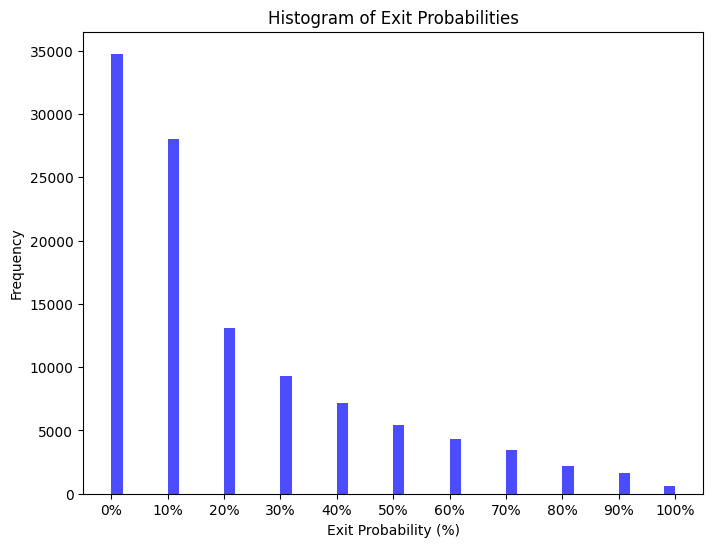

In [9]:
# Load predictions from CSV file
predictions_csv_path = 'output_predictions.csv'
df_predictions = pd.read_csv(predictions_csv_path)

# Converting probabilities to percentages
df_predictions['Exited'] = df_predictions['Exited'] * 100

# Plot the histogram of exit probabilities in percentage
plt.figure(figsize=(8, 6))
plt.hist(df_predictions['Exited'], bins=50, color='blue', alpha=0.7)
plt.xlabel('Exit Probability (%)')
plt.ylabel('Frequency')
plt.title('Histogram of Exit Probabilities')
plt.xticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], ['0%', '10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', '100%'])
plt.show()

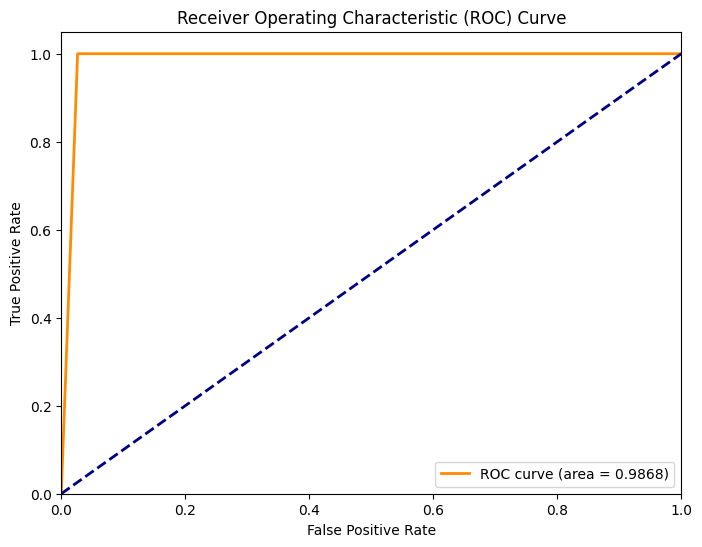

In [10]:
# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y_test_rounded, y_test_pred_binary)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.4f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Gratitude
## Thank you for following my project. Your interest and support means a lot.